# Tutorial 12: Batch effect correction

## Set up

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import umap

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
import gc
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
import matplotlib as mpl

mpl.rcParams["pdf.fonttype"] = 42

In [3]:
import random


def setup_seed(seed):
    """
    Set random seed.

    Parameters
    ----------
    seed
        Number to be set as random seed for reproducibility.

    """
    np.random.seed(seed)
    random.seed(seed)


setup_seed(2025)

In [5]:
def z_score_rows(x, center=True, scale=True, max_value=10):
    # Centering and scaling along rows
    if center:
        x = x - np.mean(x, axis=1, keepdims=True)
    if scale:
        x = x / np.std(x, axis=1, keepdims=True)
    if max_value is not None:
        x = np.clip(x, -max_value, max_value)
    return x

In [ ]:
emb_AD_rep1 = sc.read(
    "embedding/AD_mouse_rep1.h5ad"
)
emb_AD_rep1

AnnData object with n_obs × n_vars = 10366 × 512
    obs: 'cell_id', 'center_x', 'center_y', 'n_spots', 'n_genes', 'cell_orig_id', 'cell_total_id', 'p-tau', 'Aβ', 'ct_top', 'ct_sub'
    obsm: 'spatial'

In [ ]:
emb_WT_rep1 = sc.read(
    "embedding/WT_mouse_rep1.h5ad"
)
emb_WT_rep1

AnnData object with n_obs × n_vars = 8000 × 512
    obs: 'cell_id', 'center_x', 'center_y', 'n_spots', 'n_genes', 'cell_orig_id', 'cell_total_id', 'ct_top', 'ct_sub'
    obsm: 'spatial'

In [ ]:
emb_WT_rep1.obs["batch"] = "emb_WT_rep1"
emb_AD_rep1.obs["batch"] = "emb_AD_rep1"

adata_combined_4 = sc.concat([emb_WT_rep1, emb_AD_rep1])
adata_combined_4

/home/lisijie/anaconda3/envs/pyg_backup/lib/python3.11/site-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 18366 × 512
    obs: 'cell_id', 'center_x', 'center_y', 'n_spots', 'n_genes', 'cell_orig_id', 'cell_total_id', 'ct_top', 'ct_sub', 'batch'
    obsm: 'spatial'

In [ ]:
def preprocess_squidpy(adata_input, random_seed: int = 2025):
    adata = adata_input.copy()

    adata.layers["counts"] = adata.X.copy()
    sc.pp.normalize_total(adata, inplace=True, target_sum=10)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=300)
    adata.X = z_score_rows(adata.X)
    sc.pp.pca(adata, random_state=random_seed)
    sc.pp.neighbors(adata, random_state=random_seed)
    sc.tl.umap(adata, random_state=random_seed)

    return adata

In [9]:
adata_combined_4_pped = preprocess_squidpy(adata_combined_4, random_seed=2025)
adata_combined_4_pped

/home/lisijie/anaconda3/envs/pyg_backup/lib/python3.11/site-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 18366 × 512
    obs: 'cell_id', 'center_x', 'center_y', 'n_spots', 'n_genes', 'cell_orig_id', 'cell_total_id', 'ct_top', 'ct_sub', 'batch'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [ ]:
import pathlib

proj_name = "preprocess_1_SpotFormer_ADandWT_rep1"
output_path = (
    f"figure/{proj_name}/"
)

path_to_create = pathlib.Path(output_path)

path_to_create.mkdir(parents=True, exist_ok=True)

In [13]:
emb_AD_rep1.obs["Aβ"].value_counts()

Aβ
0.0    10075
1.0      291
Name: count, dtype: int64

In [14]:
mapping_dict = {0.0: "None", 1.0: "Aβ"}

In [ ]:
emb_AD_rep1.obs["Aβ_cate"] = emb_AD_rep1.obs["Aβ"].map(mapping_dict)

## Visualization

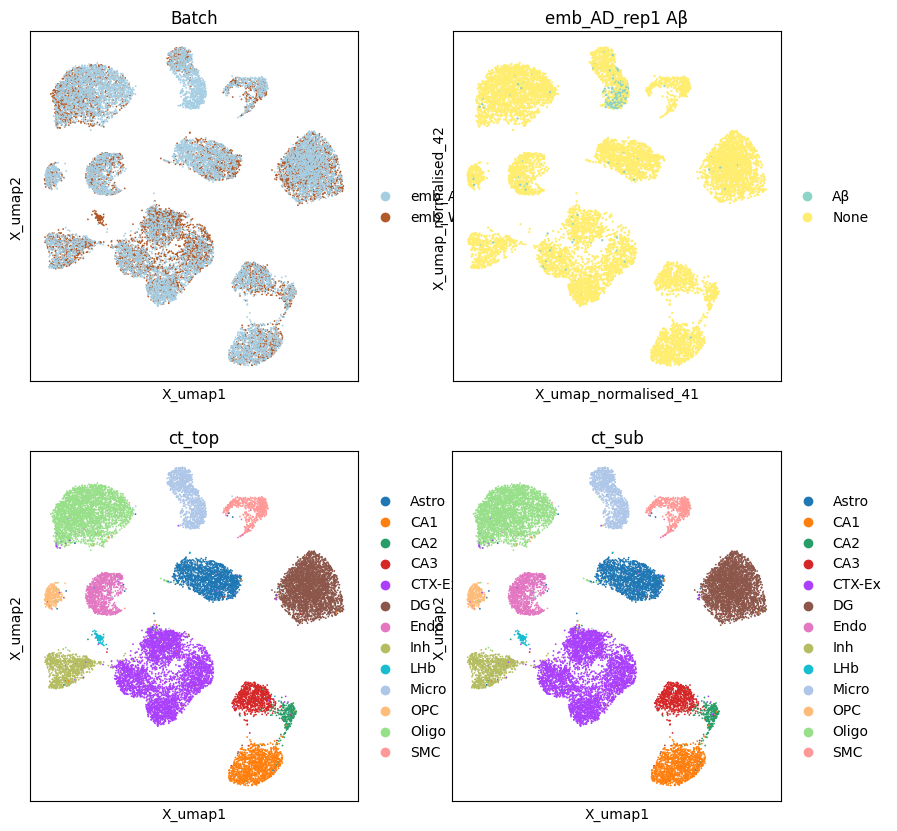

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

emb_AD_rep1.obsm["X_umap_normalised_4"] = (
    adata_combined_4_pped[adata_combined_4_pped.obs["batch"] == "emb_AD_rep1"]
    .obsm["X_umap"]
    .copy()
)

ax = axes[0, 0]
sc.pl.embedding(
    adata_combined_4_pped,
    basis="X_umap",
    color="batch",
    ax=ax,
    show=False,
    palette="Paired",
)
ax.set_title("Batch")
ax.set_aspect("equal")

ax = axes[0, 1]
sc.pl.embedding(
    emb_AD_rep1,
    basis="X_umap_normalised_4",
    color="Aβ_cate",
    ax=ax,
    show=False,
    palette="Set3",
)
ax.set_title("emb_AD_rep1 Aβ")
ax.set_aspect("equal")

ax = axes[1, 0]
sc.pl.embedding(
    adata_combined_4_pped,
    basis="X_umap",
    color="ct_top",
    ax=ax,
    show=False,
)
ax.set_title("ct_top")
ax.set_aspect("equal")

ax = axes[1, 1]
sc.pl.embedding(
    adata_combined_4_pped,
    basis="X_umap",
    color="ct_sub",
    ax=ax,
    show=False,
)
ax.set_title("ct_sub")
ax.set_aspect("equal")

plt.tight_layout()

fig.savefig(f"{output_path}/{proj_name}_abeta.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
all_categories = adata_combined_4_pped.obs["batch"].unique().tolist()
all_categories

['emb_WT_rep1', 'emb_AD_rep1']

In [ ]:
set2_cmap = plt.get_cmap("Set3")

color_wt = set2_cmap(0)
color_ad = set2_cmap(1) 

print(f"First color of 'Set2' (RGBA): {color_wt}")
print(f"Second color of 'Set2' (RGBA): {color_ad}")

color_map = {"emb_WT_rep1": color_wt, "emb_AD_rep1": color_ad}

plotting_order = ["emb_WT_rep1", "emb_AD_rep1"]

adata_combined_4_pped.obs["batch_ordered"] = pd.Categorical(
    values=adata_combined_4_pped.obs["batch"],
    categories=plotting_order,
    ordered=True,
)

print(
    "New ordered categories:", adata_combined_4_pped.obs["batch_ordered"].cat.categories.tolist()
)

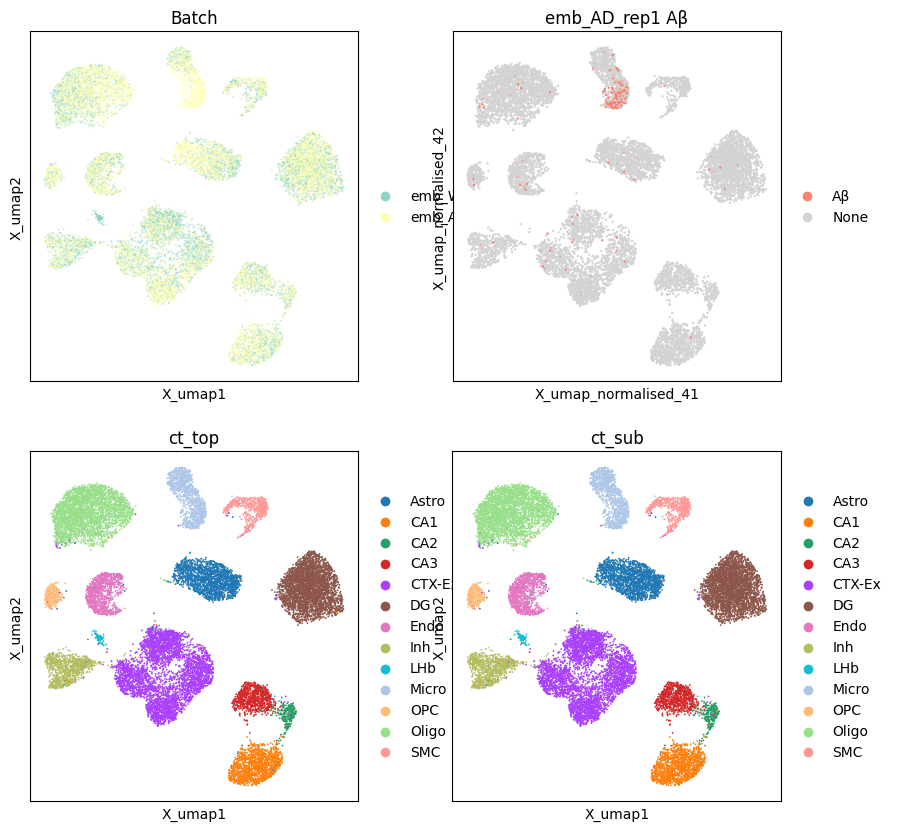

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

emb_AD_rep1.obsm["X_umap_normalised_4"] = (
    adata_combined_4_pped[adata_combined_4_pped.obs["batch"] == "emb_AD_rep1"]
    .obsm["X_umap"]
    .copy()
)

color_map_abeta = {"Aβ": "salmon", "None": "lightgray"}  # 蓝色  # 橙色

ax = axes[0, 1]
sc.pl.embedding(
    emb_AD_rep1,
    basis="X_umap_normalised_4",
    color="Aβ_cate",
    ax=ax,
    show=False,
    palette=color_map_abeta,
)
ax.set_title("emb_AD_rep1 Aβ")
ax.set_aspect("equal")

ax = axes[0, 0]
sc.pl.embedding(
    adata_combined_4_pped,
    basis="X_umap",
    color="batch_ordered",
    ax=ax,
    show=False,
    palette=color_map,
    alpha=0.5,
)
ax.set_title(f"Batch")
ax.set_aspect("equal")

ax = axes[1, 0]
sc.pl.embedding(
    adata_combined_4_pped,
    basis="X_umap",
    color="ct_top",
    ax=ax,
    show=False,
)
ax.set_title(f"ct_top")
ax.set_aspect("equal")

ax = axes[1, 1]
sc.pl.embedding(
    adata_combined_4_pped,
    basis="X_umap",
    color="ct_sub", 
    ax=ax,
    show=False,
)
ax.set_title(f"ct_sub")
ax.set_aspect("equal")

fig.savefig(f"{output_path}/{proj_name}_abeta.pdf", dpi=300)
plt.show()

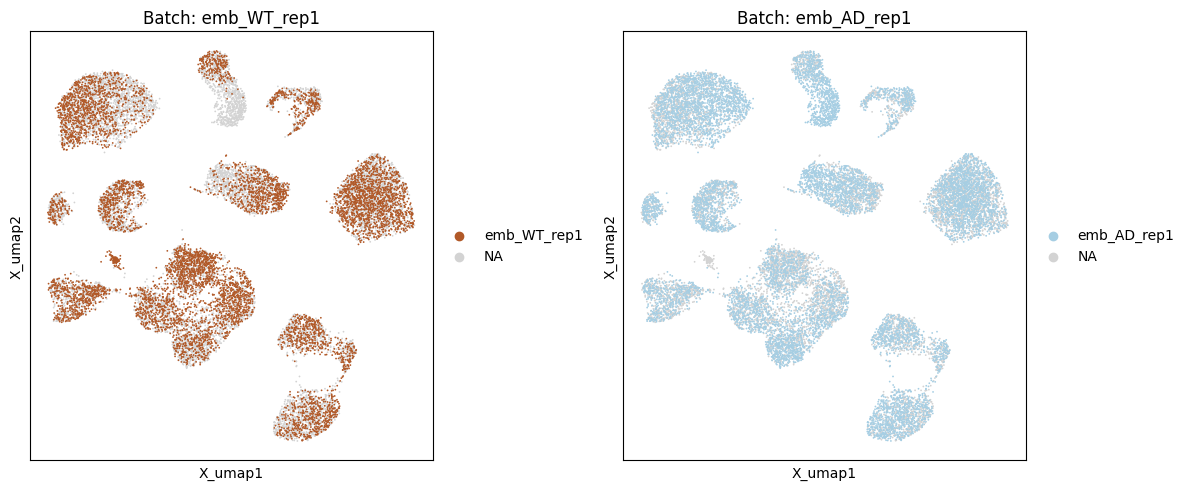

In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(12, 20))

batches = adata_combined_4_pped.obs["batch"].unique()
for ax, batch in zip(axes.flatten(), batches):
    sc.pl.embedding(
        adata_combined_4_pped,
        basis="X_umap",
        color="batch",
        groups=batch,
        ax=ax,
        show=False,
    )
    ax.set_title(f"Batch: {batch}")
    ax.set_aspect("equal")

plt.tight_layout()

fig.savefig(f"{output_path}/2.pdf", dpi=300)
plt.show()